In [1]:
#import cupy as cp
import matplotlib.pyplot as plt
#from cupyx.scipy.linalg import expm as cpx_expm
import numpy as np
#import concurrent.futures
import torch as to
from tqdm import tqdm
from scipy import special
#import gc

In [2]:
hardware = 'cuda' if to.cuda.is_available() else 'cpu'
hardware

'cuda'

In [3]:
def Ham(mz0,mz,t0,tz,tso,tsoz,ton,KY,KZ,Nx,kw,B,beta): # ky,kz 是 Batch,1
    sinteta = B/2/to.pi/beta
    costeta = to.sqrt(1-sinteta**2)
    arg0 = 2* to.sin(to.pi * beta * sinteta)
    arg1 = 2 * to.sin(to.pi * beta * costeta)
    J0 = to.special.bessel_j0(arg0)
    J1 = to.special.bessel_j1(arg1) 
    batch = KZ.shape[0]
    sigmax = to.tensor([[0, 1], [1, 0]], device=hardware)
    sigmay = to.tensor([[0, -1j], [1j, 0]], device=hardware)
    sigmaz = to.tensor([[1, 0], [0, -1]], device=hardware)
    I2 = to.eye(2,  device=hardware)
    gamma0 = to.kron(sigmaz, I2).unsqueeze(0)
    gamma1 = to.kron(sigmay, sigmax).unsqueeze(0)
    gamma2 = to.kron(sigmay, sigmay).unsqueeze(0)
    gamma3 = to.kron(sigmay, sigmaz).unsqueeze(0)
    gamma4 = to.kron(sigmax, I2).unsqueeze(0)
    sitex = to.arange(Nx, device=hardware)
    tx = -t0*J0 * gamma0 + tso*J0*1j * gamma1
    tx1 = -t0 *J0* gamma0 - tso*J0*1j * gamma1
    D = 4 * Nx
    H = to.zeros((batch, D, D), dtype=complex, device=hardware)
    sitex_expand = sitex.expand(batch, Nx)  # (batch, Nx)
    #KY = KY.expand(batch)
    cos1 = to.cos(KY + B * sitex_expand)  # (batch, Nx)
    cos2 = to.cos(KZ)     # (batch,1)
    cos3 = to.cos(kw).expand(batch,1)  
    sin1 = to.sin(KY + B * sitex_expand)  # (batch, Nx)
    sin2 = -to.sin(KZ)     # (batch,1)
    sin3 = to.sin(kw).expand(batch,1) 
    for i in range(Nx):
        onsite = (mz0 - 2*t0*J1*cos1[:, i] - 2*tz*cos2[:, 0] - mz*cos3[:, 0])[:, None, None] * gamma0 + \
                    2*tso*J1*sin1[:, i][:, None, None] * gamma2 + \
                    2*tsoz*sin2[:, 0][:, None, None] * gamma3 + \
                    ton*sin3[:, 0][:, None, None] * gamma4  # (batch,4,4)
        
            # 把 onsite 放入大矩阵 H 的对角块
        H[:, 4*i:4*(i+1), 4*i:4*(i+1)] = onsite
    for i in range(Nx - 1):
        idx1s, idx1e = i*4, (i+1)*4
        idx2s, idx2e = (i+1)*4, (i+2)*4

        H[:, idx1s:idx1e, idx2s:idx2e] = tx.expand(batch,4,4)
        H[:, idx2s:idx2e, idx1s:idx1e] = tx1.expand(batch,4,4)

        # 环边界条件
    H[:, 0:4, 4*(Nx-1):4*Nx] = tx1.expand(batch,4,4)
    H[:, 4*(Nx-1):4*Nx, 0:4] = tx.expand(batch,4,4)
    return H
    
def JZ_torch(tz,tsoz,KZ, Nx):

    batch = KZ.shape[0]
    sigmax = to.tensor([[0, 1], [1, 0]], device=hardware)
    sigmay = to.tensor([[0, -1j], [1j, 0]], device=hardware)
    sigmaz = to.tensor([[1, 0], [0, -1]], device=hardware)
    I2 = to.eye(2,  device=hardware)

    gamma0 = to.kron(sigmaz, I2).unsqueeze(0)
    gamma3 = to.kron(sigmay, sigmaz).unsqueeze(0)

    D = 4 * Nx
    H = to.zeros((batch, D, D), dtype=complex, device=hardware)

    # 计算 onsite 矩阵 (batch, 4,4)
    onsite = (2*tz*to.sin(KZ)[:,0])[:, None, None] * gamma0 + (-2*tsoz*to.cos(KZ)[:,0])[:, None, None] * gamma3  # (batch,4,4)

    for i in range(Nx):
        idx_start = i * 4
        idx_end = idx_start + 4
        H[:, idx_start:idx_end, idx_start:idx_end] = onsite

    return H

In [4]:
t0 = 0.065 #0.0855*scale
tz = 0.097
tso = 0.05 #0.0451*scale
tsoz = 0.05
ton = 0.1 #0.5674*0.15*scale
mz0 = 0.2 #*scale
mz = 0.13 #*scale

#ky = to.linspace(-to.pi,to.pi,15,device=hardware)#to.arange(-to.pi,to.pi,to.pi*2/20,device=hardware)
#kz = to.linspace(-to.pi,to.pi,15,device=hardware) #to.arange(-to.pi,to.pi,to.pi*2/40,device=hardware)
#KY,KZ = to.meshgrid(ky,kz,indexing='ij')
#KY = KY.reshape(-1,1)
#KZ = KZ.reshape(-1,1)
N=40
Nx= 80
#kw = to.linspace(0,2*to.pi,15,device=hardware)
B = (to.arange(0, 2*N/2 + 2.5, 10/2.5, device=hardware) / N) * (to.pi/2)

gap_minB = to.zeros((len(B)))
for Bi in to.arange(len(B)):
    B0 = B[Bi]
    beta = to.sqrt(to.tensor(2, device=hardware))
    D = 4 * Nx

    prev_gap = None
    n = 5
    max_iter = 5
    it = 0

    while it < max_iter:
        ky = to.linspace(-to.pi, to.pi, n, device=hardware)
        kz = to.linspace(-to.pi, to.pi, n, device=hardware)
        kw = to.linspace(0, 2*to.pi, n, device=hardware)

        KY, KZ = to.meshgrid(ky, kz, indexing='ij')
        KY = KY.reshape(-1, 1)
        KZ = KZ.reshape(-1, 1)

        gap_min = to.tensor(float("inf"), device=hardware)
        best_iw = 0
        best_ik = None

        for iw in range(n):
            H = Ham(mz0, mz, t0, tz, tso, tsoz, ton, KY, KZ, Nx, kw[iw], B0, beta)
            e = to.linalg.eigvalsh(H)
            gap = e[:, 2*Nx] - e[:, 2*Nx - 1]
            gmin, ik = gap.min(0)
            if gmin < gap_min:
                gap_min, best_iw, best_ik = gmin, iw, ik

        ky_min = KY[best_ik, 0]
        kz_min = KZ[best_ik, 0]
        kw_min = kw[best_iw]

        if prev_gap is not None and to.isclose(gap_min, prev_gap, rtol=1e-7, atol=1e-9).item():
            break
        prev_gap = gap_min
        n = 2*n-1
        it += 1
    gap_minB[Bi] = gap_min.item()
    gap_min.item(), ky_min.item(), kz_min.item(), kw_min.item(), n, it


(0.0, 2.0)

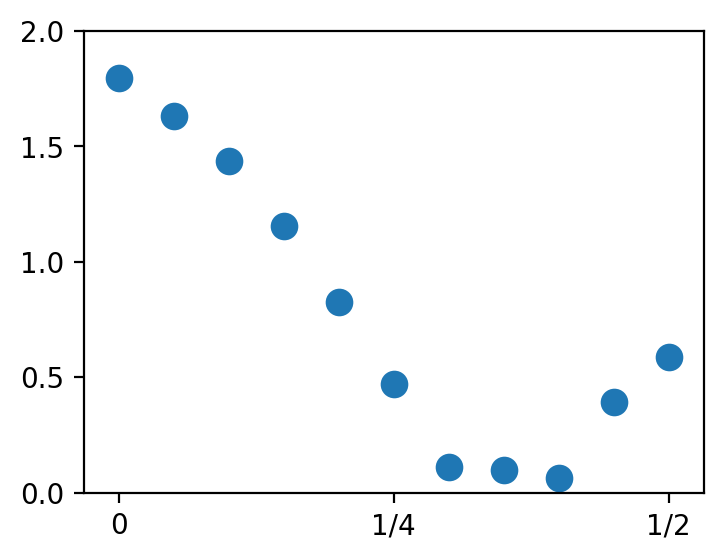

In [5]:
plt.figure(figsize=(4,3),dpi=200)
plt.xlim(-0.1,np.pi/2+0.1)
plt.xticks([0,np.pi/4,np.pi/2],['0','1/4','1/2'])
plt.scatter(B.cpu().numpy(),gap_minB.cpu().numpy()/0.065,s=80)

plt.yticks([0,0.5,1,1.5,2])
plt.ylim(0,2)
#plt.savefig('gapmin.svg')

In [7]:
data = np.column_stack([B.cpu().numpy(), gap_minB.cpu().numpy()/0.065])

np.savetxt(
    "Fig4(c)Right.txt",
    data,
    delimiter="\t",
    header=r"\tB\tGap",
    comments=""
)

In [11]:
# ky/kz 网格（保持你的设定）
t0 = 0.065 #0.0855*scale
tz = 0.097
tso = 0.05 #0.0451*scale
tsoz = 0.05
ton = 0.1 #0.5674*0.15*scale
mz0 = 0.2 #*scale
mz = 0.13 #*scale
ky = to.arange(-to.pi, to.pi, 2*to.pi/40, device=hardware)
kz = to.arange(-to.pi, to.pi, 2*to.pi/40, device=hardware)
beta = to.sqrt(to.tensor(2,device=hardware))
N = 40
Nx = 80
D = 4 * Nx

kw = to.tensor([0], device=hardware)

# 注意：B 最好也放到 GPU，避免每次 B[i] CPU->GPU
B = (to.arange(0, 2*N/2 + 2.5, 10/2.5, device=hardware) / N) * (to.pi/2)

time_array = to.arange(0, 500, 0.5, device=hardware)
kwtime = time_array / time_array[-1] * 2 * to.pi + kw
dt = time_array[1] - time_array[0]

dkz = kz[1] - kz[0]
dky = ky[1] - ky[0]

# 归一化因子（保持你原式）
pref = dkz * dky / 2 / Nx / (2*to.pi) / (2*to.pi)

# ky 分块：每次 10 个 ky
chunk_size = 40
ky_chunks = ky.split(chunk_size)

In [ ]:
# ky/kz 网格（保持你的设定）

Charge = to.zeros(len(B), device=hardware)
COMtime = to.zeros((len(B), len(time_array)), device=hardware)

for i in range(len(B)):

    # 用于累加所有 ky 块的贡献（注意：这里先累加“未乘 pref”的量）
    Charge_sum = to.zeros((), device=hardware)                  # 标量
    COM_sum = to.zeros((len(time_array),), device=hardware)     # (T,)

    for ky_block in ky_chunks:
        # 构造该块的 (ky,kz) 网格
        KY_blk, KZ_blk = to.meshgrid(ky_block, kz, indexing='ij')
        KY_blk = KY_blk.reshape(-1, 1)
        KZ_blk = KZ_blk.reshape(-1, 1)
        batch_blk = KY_blk.shape[0]

        # 该块的 Jz（只依赖 KZ 和 Nx，按你的接口）
        Jz_blk = JZ_torch(tz, tsoz, KZ_blk, Nx)  # (batch_blk, D, D)

        with to.no_grad():
            # 初态：对每个 (ky,kz) 点做对角化，构造占据态投影 rho = Vocc Vocc^\dagger
            H0 = Ham(mz0, mz, t0,tz, tso,tsoz, ton, KY_blk, KZ_blk, Nx, kw, B[i],beta)
            evals, evecs = to.linalg.eigh(H0)                   # evecs: (batch_blk, D, D)
            Vocc = evecs[:, :, :2*Nx]                           # (batch_blk, D, 2Nx)
            rho = to.bmm(Vocc, Vocc.conj().transpose(1, 2))     # (batch_blk, D, D)

            # 释放不再需要的大对象
            del H0, evals, evecs, Vocc
            to.cuda.empty_cache()

            # 对该块：每个时间步只累计 sum_{ky,kz} Tr(rho Jz)*dt  ——不存 (batch,T)
            dcom_sum_t = to.zeros((len(time_array),), device=hardware)

            for ti, t in enumerate(tqdm(time_array, desc=f'Time evolution (B[{i}], ky block)')):
                Ht = Ham(mz0, mz, t0,tz, tso,tsoz, ton, KY_blk, KZ_blk, Nx, kwtime[ti], B[i],beta)
                U = to.matrix_exp(-1j * Ht * dt)

                rho = to.bmm(to.bmm(U, rho), U.conj().transpose(1, 2))

                # sum over batch: 先算每个点的 Tr(rho Jz)，再 sum
                tr_rhoJ = to.einsum('bii->b', to.bmm(rho, Jz_blk))   # (batch_blk,)
                dcom_sum_t[ti] = tr_rhoJ.sum() * dt                 # 标量/步

                # 释放当前步临时量（减轻峰值）
                del Ht, U, tr_rhoJ

            # 累加该块对总积分的贡献
            COM_sum += dcom_sum_t
            Charge_sum += dcom_sum_t.sum()

            # 清理该块
            del rho, dcom_sum_t

        del KY_blk, KZ_blk, Jz_blk
        to.cuda.empty_cache()

    # 所有 ky 块完成后再乘 pref（与你原来一致）
    COMtime[i] = COM_sum * pref
    Charge[i] = Charge_sum * pref

    print("Charge[", i, "] =", Charge[i].item())


Time evolution (B[0], ky block): 100%|██████████| 1000/1000 [1:47:08<00:00,  6.43s/it]


Charge[ 0 ] = -1.7014743036725122e-07


Time evolution (B[1], ky block):  34%|███▍      | 341/1000 [36:29<1:10:29,  6.42s/it]

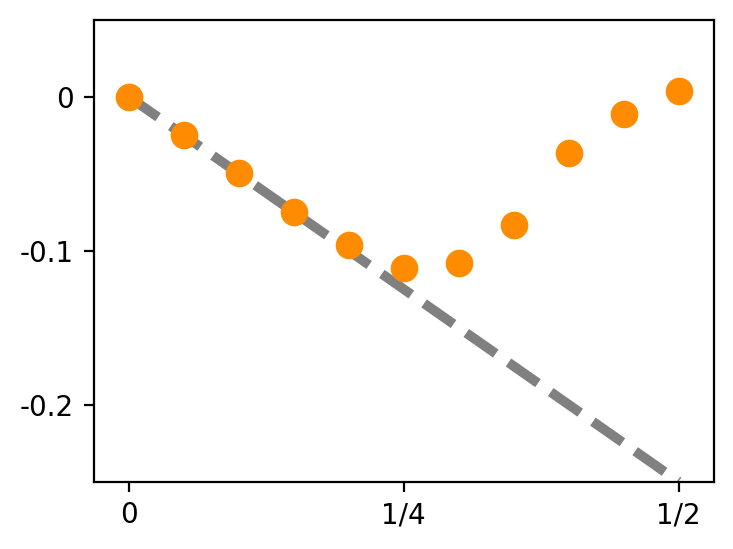

In [ ]:
plt.figure(figsize=(4,3),dpi=200)
plt.scatter(B.cpu().numpy(),Charge.cpu().numpy(),s=80,c='darkorange',zorder=2)
plt.plot(B.cpu().numpy(),-B.cpu().numpy()/2/np.pi*2/2,ls='--',linewidth=3.5,zorder=1,c='gray')
plt.xlim(-0.1,np.pi/2+0.1)
plt.ylim(-0.25,0.05)
plt.xticks([0,np.pi/4,np.pi/2],['0','1/4','1/2'])
plt.yticks([0,-0.1,-0.2],['0','-0.1','-0.2'])
#plt.savefig('CME.svg')